# Machine Learning II Project - Customer Segmentation


Group 17
- Joel Mendes - 20221825
- Lourenço Martins - 20222043
- Margarida Sardinha - 20221959

This project's goal is to segment a fictional retail company's customers into clusters, based on their demographic and purchasing data, and then create targeted promotions for each cluster detected.

This jupyter noteboook includes all functions and code that is required for our clustering solution, and that is the basis for the coupons and promotions created.

## Importing data and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Importing functions
from sklearn.metrics import confusion_matrix, silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from sklearn.cluster import estimate_bandwidth

from preprocessing_py_files.preprocessing import *
from preprocessing_py_files.feature_engineering import *
from preprocessing_py_files.feature_selection import *

from visualization_py_files.initial_visualizations import *
from visualization_py_files.ploting import *

from modeling_py_files.dimensionality_reduction import *
from modeling_py_files.modeling import *
from modeling_py_files.association_rules import *

from extra_py_files.ExtraCredit import *
from extra_py_files.helping_functions import *

In [2]:
cust_basket = pd.read_csv('data/customer_basket.csv')
cust_info = pd.read_csv('data/customer_info.csv', index_col=0)
product_mapping = pd.read_excel('data/product_mapping.xlsx')

## Exploratory Data Analysis

The first step of any ML project is to clean and visualize the data one is working with. This, in our case, included creating variables and removing unwanted ones, scaling all numerical variables, and removing outliers, both random and those that form clusters a priori.

In [3]:
# Initial visualizations
display(cust_info.head())
display(cust_info.describe())

,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,39634,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,7106.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
1,43460,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,1334.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
2,23937,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,4073.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105
3,2431,Ora Boggess,female,06/15/1941 03:26 AM,0.0,0.0,0.0,1.0,10825.0,207.0,...,151.0,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318
4,10090,Lonnie Hopson,male,12/18/2001 03:03 AM,0.0,0.0,0.0,1.0,697.0,570.0,...,172.0,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024


,customer_id,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
count,43631.000000,43107.000000,42610.000000,42977.000000,42322.000000,43631.000000,43631.000000,41886.000000,42758.000000,43631.000000,...,42322.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,24654.000000,43631.000000,43631.000000
mean,24993.120877,1.081263,0.847829,0.705726,1.669959,5600.030047,2000.058468,13.520580,456.893938,443.636657,...,1471.423846,916.948408,990.334922,2023.225619,387.260182,0.229431,2011.342257,949808.661069,38.752266,-9.158591
std,14426.310863,1.239257,0.840397,0.624624,1.034825,4602.647746,3004.924537,4.558057,312.832282,210.313287,...,3910.163766,729.744050,1241.658577,2926.355387,411.436756,0.189242,4.656129,28894.251301,0.048629,0.036606
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.477986,1996.000000,900008.000000,38.690636,-9.418076
25%,12521.500000,0.000000,0.000000,0.000000,1.000000,2184.500000,218.000000,10.000000,227.000000,297.000000,...,187.000000,372.000000,204.000000,517.000000,97.000000,0.111704,2008.000000,924774.000000,38.732481,-9.175824
50%,24988.000000,1.000000,1.000000,1.000000,1.000000,4071.000000,574.000000,13.000000,387.000000,419.000000,...,641.000000,668.000000,557.000000,874.000000,252.000000,0.205235,2011.000000,949681.000000,38.748887,-9.160152
75%,37484.500000,1.000000,1.000000,1.000000,2.000000,6605.500000,2565.500000,17.000000,584.000000,560.000000,...,1570.000000,1437.000000,1111.000000,2217.000000,537.000000,0.310884,2014.000000,975117.250000,38.764504,-9.139240
max,50000.000000,9.000000,6.000000,9.000000,8.000000,26552.000000,21273.000000,24.000000,2112.000000,2224.000000,...,50381.000000,3487.000000,5389.000000,19596.000000,3544.000000,1.196858,2024.000000,999996.000000,39.357600,-9.055377


In [4]:
display(cust_basket.head())
display(cust_basket.describe(include=object))

,invoice_id,list_of_goods,customer_id
0,7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
1,3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
2,10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134
3,12179179,"['babies food', 'milk', 'rice', 'yogurt cake',...",43134
4,8292388,"['napkins', 'cookies', 'razor', 'cooking oil',...",43134


,list_of_goods
count,89952
unique,88767
top,"['babies food', 'cooking oil']"
freq,25


#### Inconsistencies found

In [5]:
# Variables with missing values
cust_info.isnull().sum()

customer_id                                    0
customer_name                                  0
customer_gender                                0
customer_birthdate                             0
kids_home                                    524
teens_home                                  1021
number_complaints                            654
distinct_stores_visited                     1309
lifetime_spend_groceries                       0
lifetime_spend_electronics                     0
typical_hour                                1745
lifetime_spend_vegetables                    873
lifetime_spend_nonalcohol_drinks               0
lifetime_spend_alcohol_drinks                  0
lifetime_spend_meat                            0
lifetime_spend_fish                         1309
lifetime_spend_hygiene                         0
lifetime_spend_videogames                      0
lifetime_spend_petfood                         0
lifetime_total_distinct_products               0
percentage_of_produc

In [6]:
# A percentage cannot be negative
cust_info['percentage_of_products_bought_promotion'].min()

-0.4779855680623625

## Preprocessing

#### 1. Engineering of interesting variables

In [7]:
cust_info_pp = custinfo_feature_eng(cust_info)

Added columns: age, gender, loyalty_program, education, vegetarian, lifetime_total_spent.
Droped columns: customer_birthdate, customer_gender, loyalty_card_number.



In [8]:
cust_info_pp.head()

,customer_name,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,age,gender,loyalty_program,education,vegetarian,lifetime_total_spent
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,484.0,604.0,...,0.072206,2010.0,38.735637,-9.149071,60,0,False,12,0,42391.0
43460,Belinda Terry,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,344.0,374.0,...,0.206227,2014.0,38.762702,-9.160802,36,1,False,12,0,18973.0
23937,Evelyn Calico,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,301.0,852.0,...,0.136168,2009.0,38.717431,-9.165105,55,1,True,12,0,18957.0
2431,Ora Boggess,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,153.0,252.0,...,0.215852,2007.0,38.782169,-9.150318,83,1,True,12,0,16191.0
10090,Lonnie Hopson,0.0,0.0,0.0,1.0,697.0,570.0,NaN,8.0,33.0,...,0.181023,2024.0,38.770397,-9.177024,22,0,True,12,0,5245.0


In [9]:
# Applying the preproc functions to customer_basket
basket_treated = cust_basket_preproc(cust_basket)
basket_encoded = cust_basket_encoding(basket_treated)

#### 2. Uni Dimensional Outliers Identification

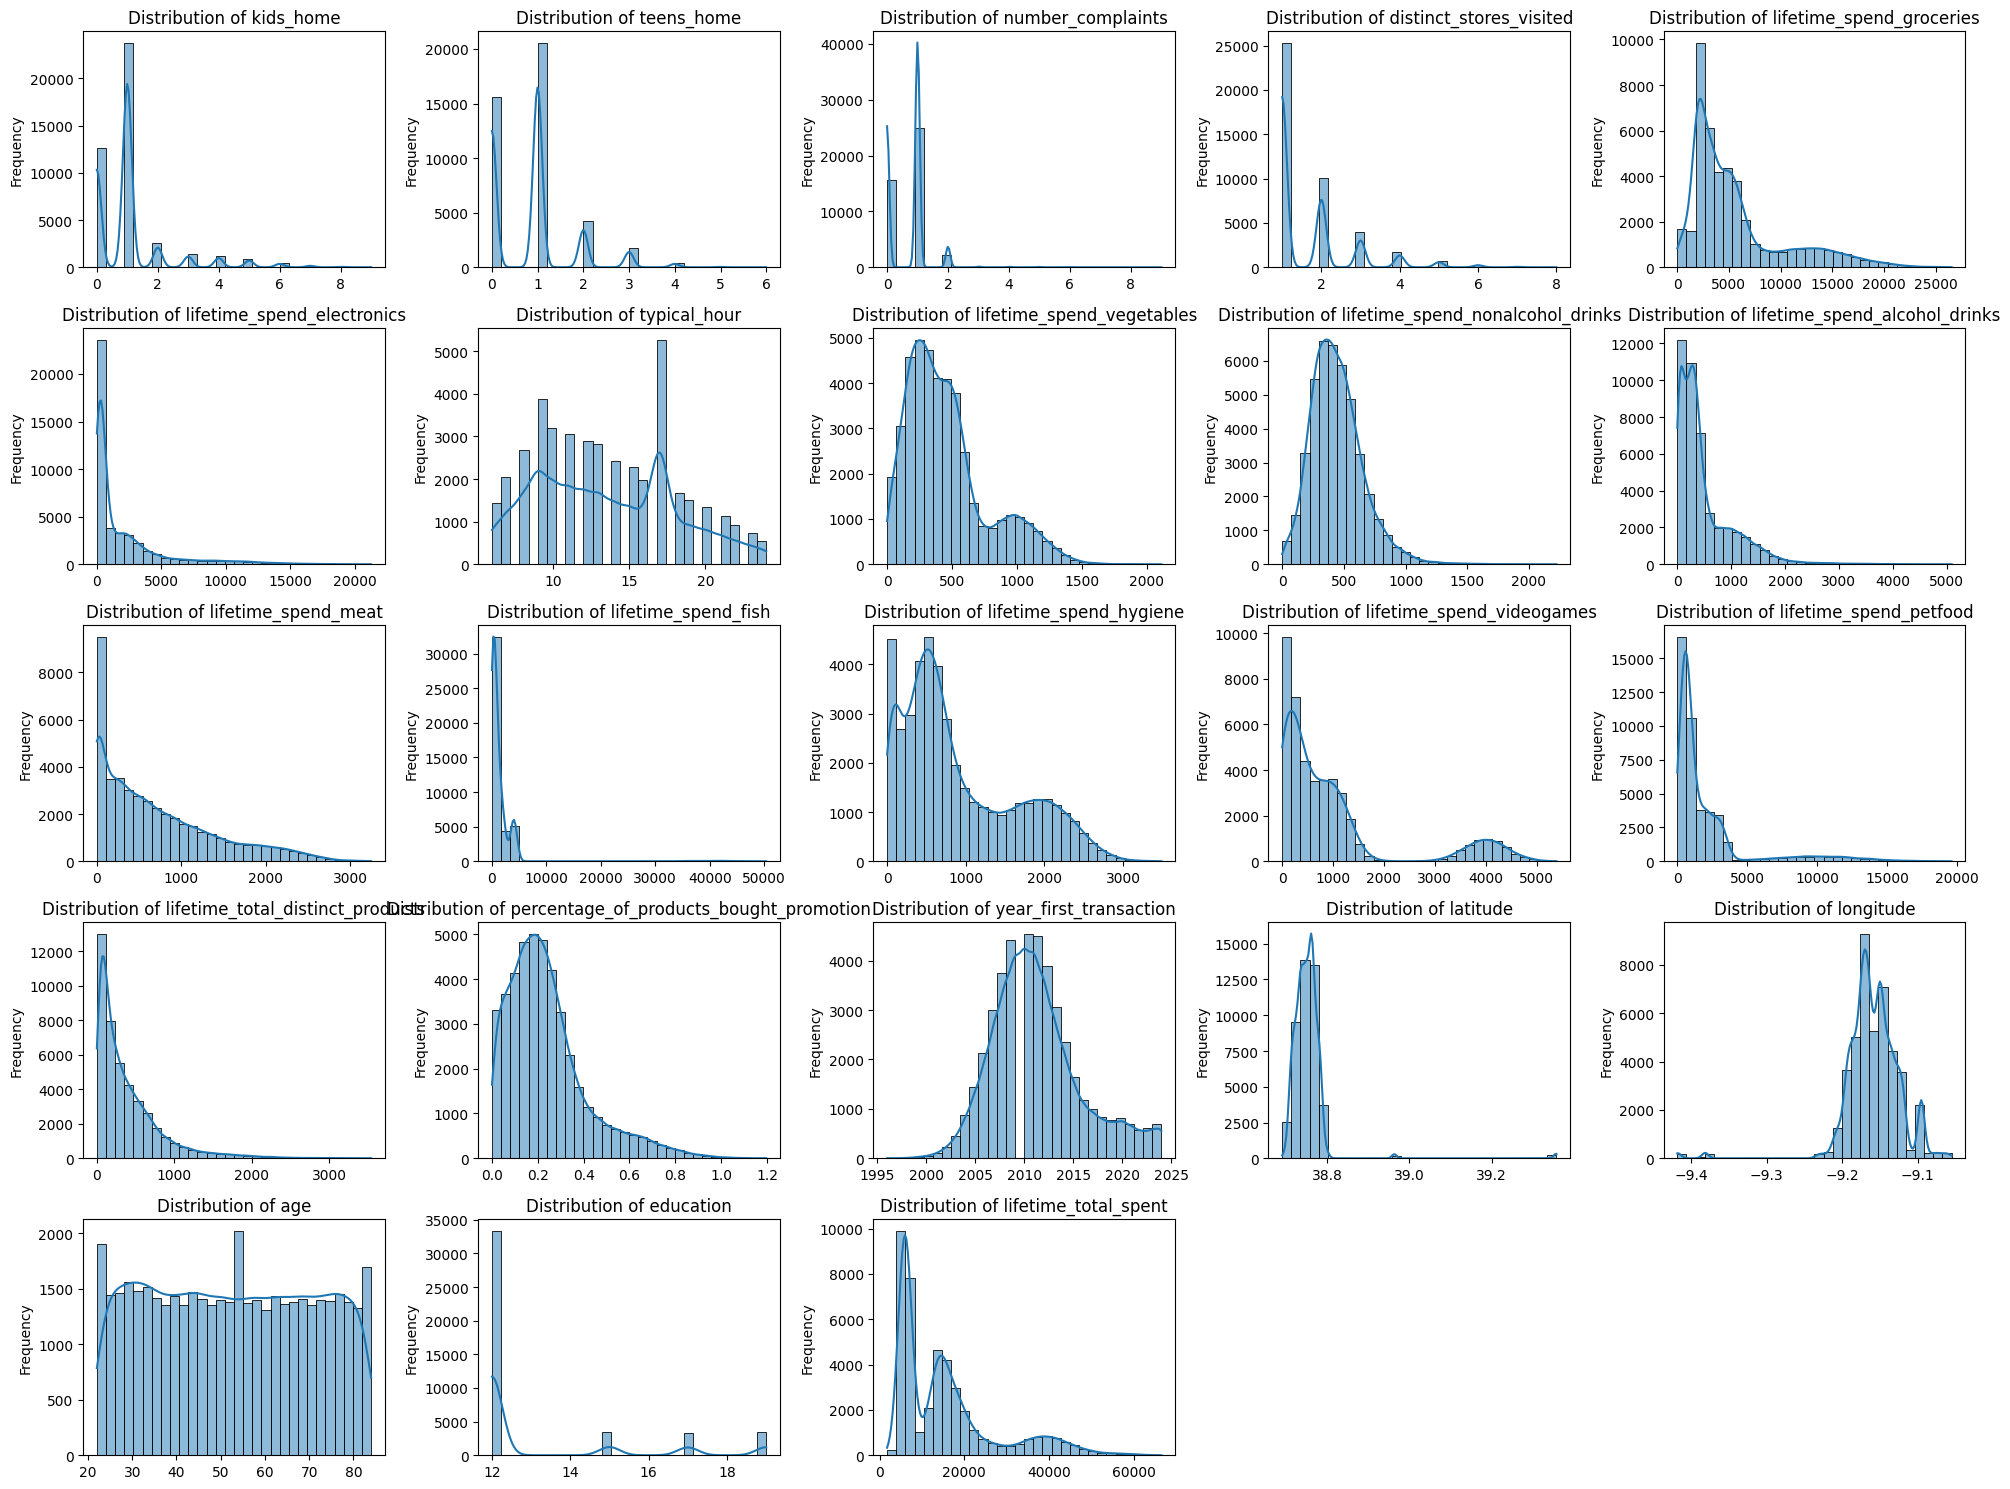

In [10]:
plot_distributions_grid(cust_info_pp, cols_to_drop=['customer_name', 'gender', 'vegetarian'], 
                        figsize=(20, 15), bins=30)

Variables in need of further investigatigation:
- lifetime_spend_fish
- lifetime_spend_videogames
- lifetime_spend_petfood
- latitude and longitude

Starting with coordinates, let's identify why there is a group of people very distant from the rest.

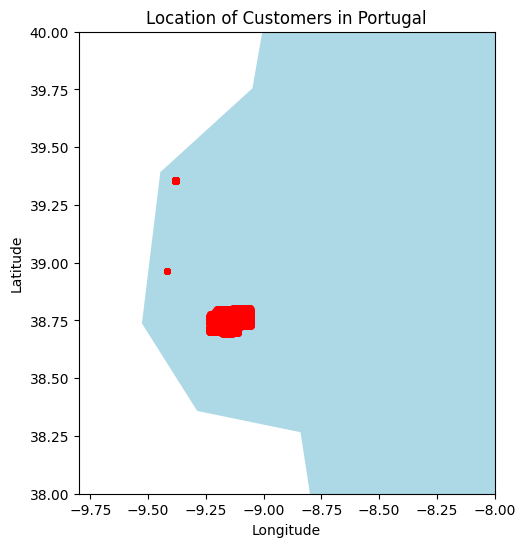

In [11]:
plot_population(cust_info)

In [12]:
fish_apriori, men_of_the_sea = find_fishermen(cust_info_pp)

In [13]:
compare(fish_apriori, men_of_the_sea)

,df1_means,df2_means
kids_home,1.09,0.02
teens_home,0.86,0.03
number_complaints,0.71,0.51
distinct_stores_visited,1.68,1.00
lifetime_spend_groceries,5525.97,13854.64
lifetime_spend_electronics,2016.32,187.31
typical_hour,13.55,10.01
lifetime_spend_vegetables,457.35,405.79
lifetime_spend_nonalcohol_drinks,444.85,308.46
lifetime_spend_alcohol_drinks,497.61,99.83


As we can see men of the sea (clients whose location is close to the ocean) do not have much relevant information, besides that they buy a lot of fish, this is group of simillar unidimensional outliers that belong to our first cluster.

#### 3. Multi-dimensional Outliers Analysis

For multi dimensional outliers we will run a KMeans algorithm with a large K which will make it more prone to identify groups of similar clients very differentiable from the rest.

In [14]:
# create test_outliers variable to store the data without fisherman for initial outlier analysis or possibly more apriori clusters
test_outliers = fish_apriori.copy()
test_outliers_train = test_outliers.drop(columns=['customer_name', 'latitude', 'longitude', 'loyalty_program'])

# run the functions that make the data ready for cluster analysis
imputation(test_outliers_train, test_outliers_train.select_dtypes(include=[np.number]).columns)
scaling(test_outliers_train, test_outliers_train.select_dtypes(include=[np.number]).columns)

test_outliers_train.head(3)

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,age,gender,education,vegetarian,lifetime_total_spent
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0.0,0.0,0.0,1.0,3.307318,2.747998,0.571429,0.270423,0.695817,1.229703,...,3.731788,0.953189,-0.509091,-0.695177,-0.166667,0.258065,-1.0,0.0,0.0,2.365362
43460,0.0,-1.0,0.0,1.0,0.229273,0.315634,-0.714286,-0.123944,-0.178707,1.772277,...,0.511038,0.644822,5.250000,0.003924,0.500000,-0.516129,0.0,0.0,0.0,0.489446
23937,-1.0,0.0,0.0,2.0,-0.214914,1.469869,-0.428571,-0.245070,1.638783,2.790099,...,1.036424,0.662961,2.331818,-0.361527,-0.333333,0.096774,0.0,0.0,0.0,0.488164


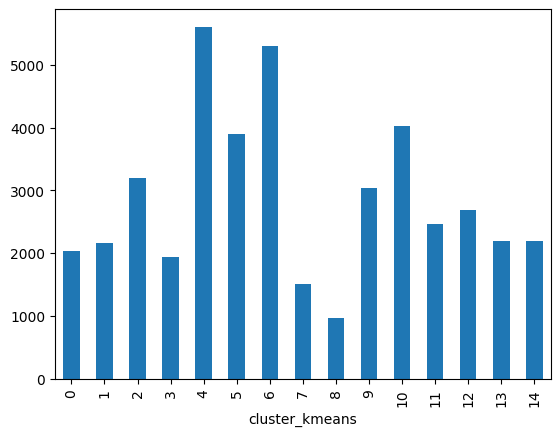

In [15]:
allocate_clusters_kmeans(test_outliers, test_outliers_train, n_clusters=15, random_state=42)
test_outliers.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

In [16]:
# analysing the smaller clusters, that are the more prone to being pushed by outliers
show_clusters(test_outliers, 'cluster_kmeans', [3, 7, 8])

Cluster 3 size: 1937
Cluster 7 size: 1513
Cluster 8 size: 976
Overall dataset size: 43243


,Overall Mean,Cluster 3 Mean,Cluster 7 Mean,Cluster 8 Mean
kids_home,1.09,1.00,1.00,0.33
teens_home,0.86,1.00,0.99,0.03
number_complaints,0.71,0.51,0.49,0.03
distinct_stores_visited,1.68,1.37,1.39,1.38
lifetime_spend_groceries,5525.97,14273.04,14070.53,915.32
lifetime_spend_electronics,2016.32,11412.13,8164.24,501.08
typical_hour,13.55,13.65,13.71,18.71
lifetime_spend_vegetables,457.35,498.59,503.13,102.73
lifetime_spend_nonalcohol_drinks,444.85,594.68,598.35,530.21
lifetime_spend_alcohol_drinks,497.61,993.36,1023.28,2210.93


Analysing the values of the 3 smallest clusters, 3 and 7 are close so they will stay in the model, although cluster number 8 is really interesting.

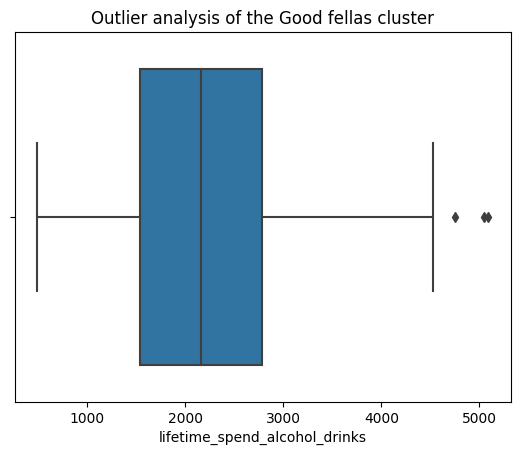

In [17]:
spend_alchool = test_outliers[test_outliers['cluster_kmeans'] == 8]["lifetime_spend_alcohol_drinks"] 

plt.figure()
sns.boxplot(x = spend_alchool)
plt.xlabel('lifetime_spend_alcohol_drinks')
plt.title('Outlier analysis of the Good fellas cluster')
plt.show()

A second group of very similar clients was identified. With small values accross the other variables, lifetime_spend_alcohol_drinks stands out drastically in this group as well as age.  
In an effort to know if this observations were closer to the average population but were being pulled away by outliers, we plotted this boxplot that proves the contrary. This is a very concise group of young alchoolics. Our second cluster.

In [18]:
# stores the apriori cluster of alchoolics (which we assume is students)
uni_students = test_outliers[test_outliers['cluster_kmeans'] == 8]

# stores the rest of the observations that do not belong to fisherman and uni students
cust_info_sep = test_outliers[test_outliers['cluster_kmeans'] != 8]

In [19]:
cust_info_sep.drop('cluster_kmeans', axis=1, inplace=True)
uni_students.drop('cluster_kmeans', axis=1, inplace=True)

In past analysis of clustering solutions we noticed that a big group of points were very similar and distanced from the rest so even tho they do not appear in this initial analysis we will identify them as an apriori cluster.  
This group is particular for its spending habits, spending a lot on pet food and very few in the rest.

In [20]:
cust_info_sep, pet_love = find_outliers(cust_info_sep, 'lifetime_spend_petfood', 2)

#### 4. Feature Selection

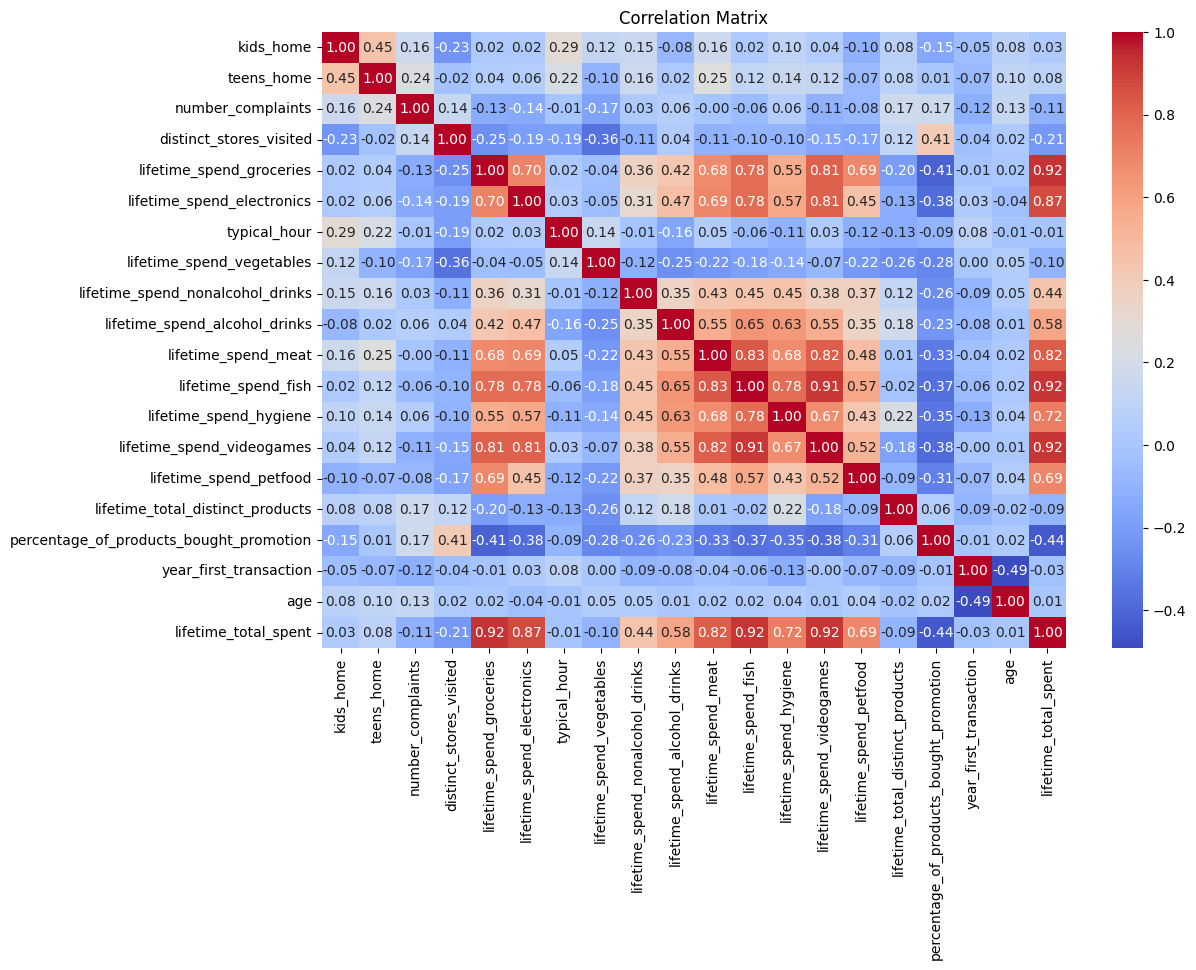

In [21]:
plot_variable_correlation(cust_info_sep, cols_to_drop=['customer_name', 'education', 'gender', 'loyalty_program', 'latitude', 'longitude', 'vegetarian'])

Based on the results above, here we remove the unwanted features, those that were too highly correlated and thus worked as proxies for another.
- lifetime_spend_videogames, 
- lifetime_spend_meat,
- lifetime_spend_fish.

In [22]:
cust_info_pp = feature_selection(cust_info_pp)

#### 5. Scalling and Imputation

In [23]:
cust_info_sep_sc = scaling_imputation(cust_info_sep)
cust_info_pp_sc = scaling_imputation(cust_info_pp)

### Final Dataframes description:
- *cust_info:* Original dataset
- *cust_info_pp:* Original but preprosseced dataset (feature engineering and selection)

- *cust_info_sep:* Preprocessed dataset without fishermen, uni students and pet lovers
- *fisherman:* Cluster of fishermans
- *uni_students:* Cluster of university students
- *pet_lovers:* Cluster of pet lovers

- *cust_info_pp_sc:* All observations preprosseced and scaled
- *cust_info_sep_sc:* Non-apriori clusters preprosseced and scaled

- *basket_treated:* Cleaned up, to serve as reference if needed
- *basket_encoded:* With TransactionEncoded applied, to be used for association rules

## Customer Segmentation

### Preparing the data

To apply to the clustering algorithms, only the variables relating to purchase history will be used.

The initial plan was to create 2 clustering solutions and merge them based on results, but due to time constraints, only the most relevant variables, the ones relating to purchase history, will be used. In future, the project could be expanded upon by utilizing the demographic variables as well.

In [24]:
cust_info_pp_sc = modelling_separator(cust_info_pp_sc)
cust_info_sep_sc = modelling_separator(cust_info_sep_sc)

### K-Means Clustering

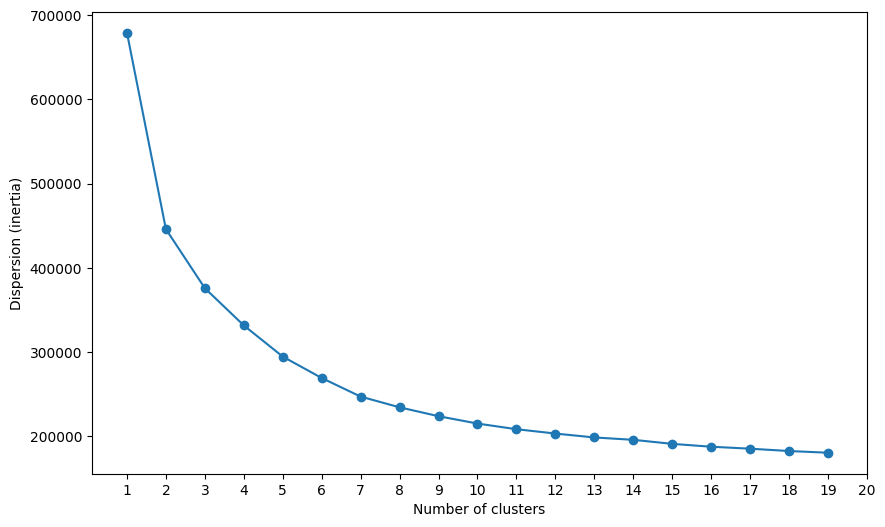

In [25]:
# Checking the optimum number of clusters to look for
dispersion_apriori = create_dispersion_list(cust_info_sep_sc)
plot_elbow_graph(dispersion_apriori)

In [26]:
calculate_silhouette_scores(cust_info_sep_sc, [6,7,8])

{6: 0.264, 7: 0.27, 8: 0.269}

In [27]:
allocate_clusters_kmeans(cust_info_sep, cust_info_sep_sc, n_clusters=7)

In [28]:
show_clusters(cust_info_sep, cluster_column='cluster_kmeans', cluster_numbers=[0,1,2,3,4,5,6])

Cluster 0 size: 5059
Cluster 1 size: 5642
Cluster 2 size: 7829
Cluster 3 size: 5232
Cluster 4 size: 7415
Cluster 5 size: 6872
Cluster 6 size: 1057
Overall dataset size: 39106


,Overall Mean,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 3 Mean,Cluster 4 Mean,Cluster 5 Mean,Cluster 6 Mean
kids_home,1.20,1.01,1.00,1.00,3.83,0.56,0.60,0.00
teens_home,0.94,0.84,1.00,0.44,2.10,0.79,0.97,0.02
number_complaints,0.74,1.07,0.50,0.51,1.00,0.58,0.96,0.50
distinct_stores_visited,1.74,2.01,1.39,1.22,1.11,1.33,3.46,1.00
lifetime_spend_groceries,5268.65,5020.15,14013.27,2936.06,5046.27,3704.33,2025.92,10215.49
lifetime_spend_electronics,2204.17,2079.61,8116.73,409.96,2036.00,1896.13,260.69,158.75
typical_hour,13.56,9.66,13.64,13.72,17.70,14.42,12.37,11.98
lifetime_spend_vegetables,487.23,299.39,499.58,996.46,500.36,335.94,233.14,200.18
lifetime_spend_nonalcohol_drinks,438.27,595.70,596.71,312.03,502.98,400.24,318.97,496.34
lifetime_spend_alcohol_drinks,491.82,1029.59,1012.77,149.97,300.53,427.73,341.86,40.63


Kmeans solution Silhouette Score: 0.33


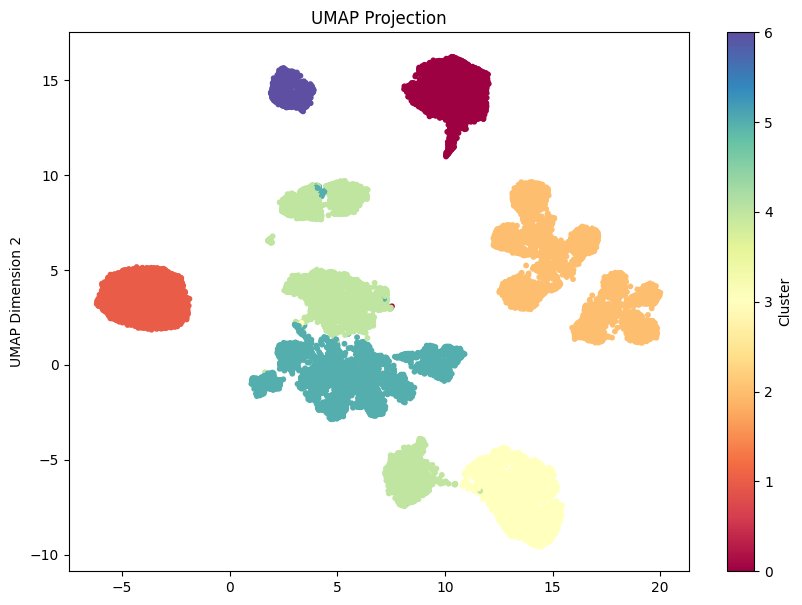

In [29]:
cust_info_sep_sc['cluster_kmeans'] = cust_info_sep['cluster_kmeans']
silhouette_kmeans = silhouette_score(cust_info_sep_sc, cust_info_sep_sc['cluster_kmeans'])

print('Kmeans solution Silhouette Score: ' + str(round(silhouette_kmeans, 2)))
apply_umap(cust_info_sep_sc, 'cluster_kmeans')

In [30]:
cust_info_sep_sc.drop('cluster_kmeans', axis=1, inplace=True)

### Hierarchical Clustering

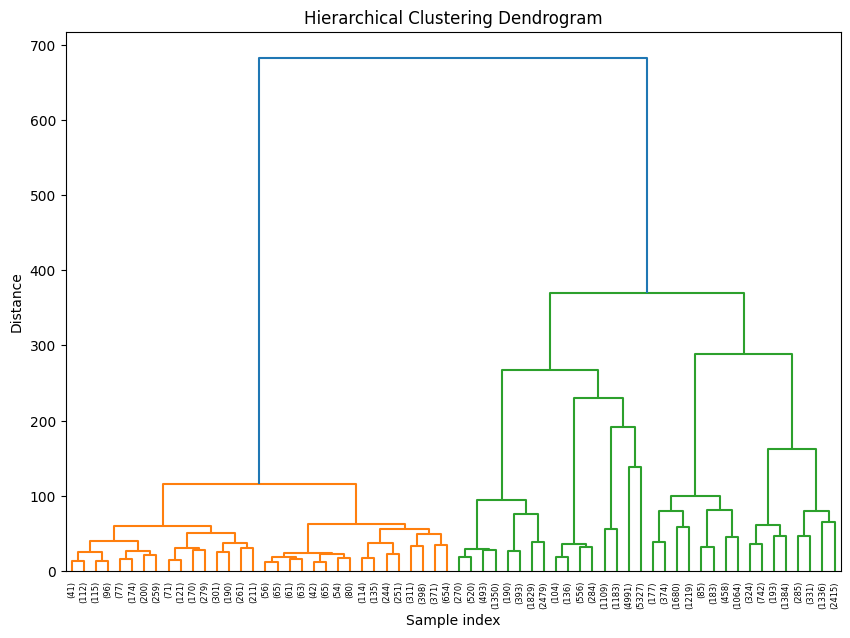

In [31]:
Z = linkage(cust_info_sep_sc, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [32]:
# Specify the number of clusters
k = 7
clusters = fcluster(Z, k, criterion='maxclust')

# Add cluster labels to the sampled DataFrame
cust_info_sep['cluster_hierarchical'] = clusters
cust_info_sep['cluster_hierarchical'] -= 1

In [33]:
show_clusters(cust_info_sep, 'cluster_hierarchical', [0,1,2,3,4,5,6])

Cluster 0 size: 5642
Cluster 1 size: 7524
Cluster 2 size: 1080
Cluster 3 size: 2292
Cluster 4 size: 10318
Cluster 5 size: 5240
Cluster 6 size: 7010
Overall dataset size: 39106


,Overall Mean,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 3 Mean,Cluster 4 Mean,Cluster 5 Mean,Cluster 6 Mean
kids_home,1.20,1.00,1.00,0.00,0.11,0.63,1.00,3.08
teens_home,0.94,1.00,0.43,0.02,0.00,0.92,0.84,2.01
number_complaints,0.74,0.50,0.52,0.49,0.03,0.85,1.13,1.00
distinct_stores_visited,1.74,1.39,1.19,1.00,1.40,2.77,2.02,1.11
lifetime_spend_groceries,5268.65,14013.27,2985.29,10167.78,5000.75,1988.60,4997.89,5044.41
lifetime_spend_electronics,2204.17,8116.73,408.99,159.06,4062.00,276.46,2068.83,2018.45
typical_hour,13.56,13.64,13.75,11.95,13.78,12.72,9.74,17.59
lifetime_spend_vegetables,487.23,499.58,997.30,200.81,298.29,269.52,297.43,498.60
lifetime_spend_nonalcohol_drinks,438.27,596.71,307.76,495.83,298.94,355.50,582.45,501.59
lifetime_spend_alcohol_drinks,491.82,1012.77,135.16,40.51,494.57,371.90,1026.78,300.59


Hierarchical solution Silhouette Score: 0.34


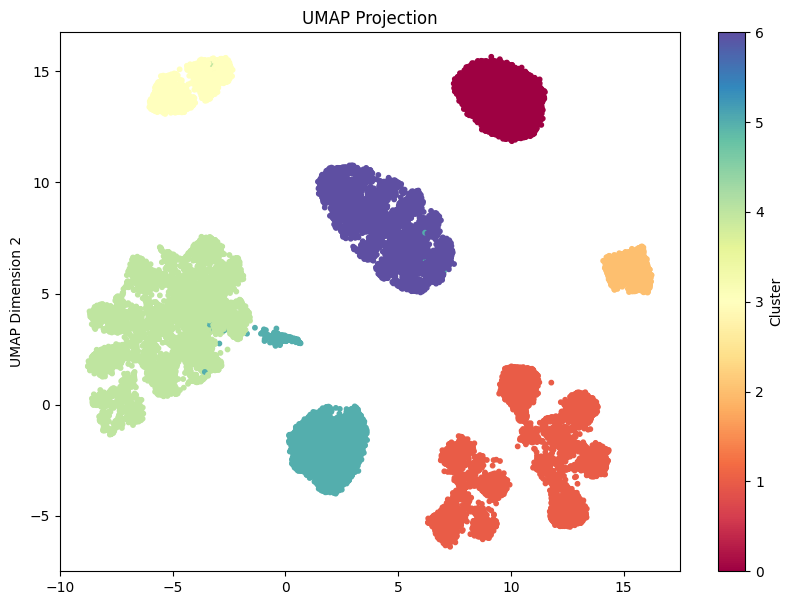

In [34]:
cust_info_sep_sc['cluster_hierarchical'] = cust_info_sep['cluster_hierarchical']
silhouette_hierarchical = silhouette_score(cust_info_sep_sc, cust_info_sep_sc['cluster_hierarchical'])

print('Hierarchical solution Silhouette Score: ' +  str(round(silhouette_hierarchical, 2)))
apply_umap(cust_info_sep_sc, 'cluster_hierarchical')

In [35]:
cust_info_sep_sc.drop('cluster_hierarchical', axis=1, inplace=True)

Cluster solution crossing between K-Means and Hierarchical

In [36]:
pd.DataFrame(
    confusion_matrix(cust_info_sep.cluster_kmeans, cust_info_sep.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,7)],
    columns = ['Hierarchical {} Cluster'.format(i) for i in np.arange(0,7)],
)

,Hierarchical 0 Cluster,Hierarchical 1 Cluster,Hierarchical 2 Cluster,Hierarchical 3 Cluster,Hierarchical 4 Cluster,Hierarchical 5 Cluster,Hierarchical 6 Cluster
K-means 0 Cluster,0,0,0,3,54,4956,46
K-means 1 Cluster,5642,0,0,0,0,0,0
K-means 2 Cluster,0,7424,0,0,393,1,11
K-means 3 Cluster,0,0,0,0,5,4,5223
K-means 4 Cluster,0,79,23,2270,3110,204,1729
K-means 5 Cluster,0,21,0,19,6756,75,1
K-means 6 Cluster,0,0,1057,0,0,0,0


### DBSCAN

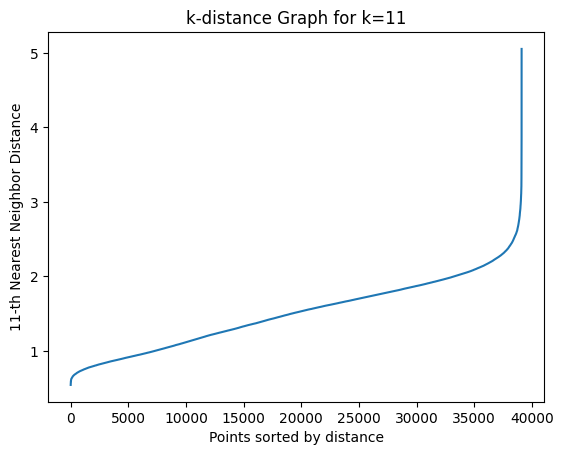

In [37]:
# Plot the k-distance graph
plot_k_distance(cust_info_sep_sc, k=11)

In [38]:
# Calculate the distance matrix
sample_df = cust_info_sep_sc.sample(5000, random_state=42)

dist_matrix = distance_matrix(sample_df, sample_df)

# Summary statistics of pairwise distances
print('Min distance:', np.min(dist_matrix))
print('Max distance:', np.max(dist_matrix))
print('Mean distance:', np.mean(dist_matrix))
print('Median distance:', np.median(dist_matrix))

Min distance: 0.0
Max distance: 13.536408002010916
Mean distance: 5.547834966149282
Median distance: 5.185463830850474


In [39]:
eps_range = np.arange(1.5, 2.4, 0.1)
min_samples_range = range(5, 36, 5)

# Grid search over the parameter ranges
for min_samples in min_samples_range:
    for eps_val in eps_range:
        model = DBSCAN(eps=eps_val, min_samples=min_samples)
        labels = model.fit_predict(cust_info_sep_sc)

        clusters, noise_points = print_dbscan_info(labels)

        print(f'eps: {round(eps_val,2)}, min_samples: {min_samples}')
        print(f'Cluster sizes: {clusters}')
        print(f'Number of noise points: {noise_points}')
        print('-' * 40)

eps: 1.5, min_samples: 5
Cluster sizes: {0: 1074, 1: 1832, 2: 10, 3: 5, 4: 3, 5: 5, 6: 4, 7: 5, 8: 10, 9: 5, 10: 4, 11: 5, 12: 4, 13: 6, 14: 24105, 15: 4, 16: 2, 17: 5, 18: 3, 19: 6, 20: 7, 21: 2, 22: 8, 23: 24, 24: 3, 25: 7, 26: 6, 27: 6, 28: 6, 29: 4, 30: 4, 31: 4, 32: 4, 33: 7, 34: 4, 35: 4, 36: 5, 37: 7, 38: 3, 39: 6, 40: 5, 41: 4, 42: 4, 43: 4}
Number of noise points: 11871
----------------------------------------
eps: 1.6, min_samples: 5
Cluster sizes: {0: 1078, 1: 2895, 2: 7, 3: 6, 4: 3, 5: 3, 6: 5, 7: 7, 8: 7, 9: 4, 10: 4, 11: 5, 12: 6, 13: 3, 14: 4, 15: 26400, 16: 5, 17: 4, 18: 5, 19: 5, 20: 5, 21: 4, 22: 3, 23: 5, 24: 4, 25: 3, 26: 5, 27: 4, 28: 7, 29: 12, 30: 3, 31: 1, 32: 6, 33: 5, 34: 2, 35: 5, 36: 4, 37: 5}
Number of noise points: 8567
----------------------------------------
eps: 1.7, min_samples: 5
Cluster sizes: {0: 1079, 1: 3847, 2: 3, 3: 4, 4: 5, 5: 3, 6: 6, 7: 5, 8: 3, 9: 4, 10: 28294, 11: 7, 12: 2, 13: 3, 14: 4, 15: 5, 16: 4, 17: 5, 18: 3, 19: 5, 20: 4, 21: 2, 22: 

In [40]:
allocate_clusters_dbscan(cust_info_sep, cust_info_sep_sc, eps=1.5, min_samples=35)

In [41]:
show_clusters(cust_info_sep, cluster_column='cluster_dbscan', cluster_numbers=[0,1,2,3,4,5,6])

Cluster 0 size: 1018
Cluster 1 size: 35
Cluster 2 size: 327
Cluster 3 size: 1940
Cluster 4 size: 2876
Cluster 5 size: 14832
Cluster 6 size: 78
Overall dataset size: 39106


,Overall Mean,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 3 Mean,Cluster 4 Mean,Cluster 5 Mean,Cluster 6 Mean
kids_home,1.20,0.00,1.00,1.00,0.07,2.93,0.77,0.22
teens_home,0.94,0.01,1.00,0.99,0.00,1.98,0.71,0.00
number_complaints,0.74,0.50,0.00,1.01,0.01,0.99,0.75,0.00
distinct_stores_visited,1.74,1.00,1.06,1.98,1.25,1.04,2.07,1.17
lifetime_spend_groceries,5268.65,10192.60,15049.89,5198.24,4972.88,5035.11,2502.06,944.69
lifetime_spend_electronics,2204.17,158.46,10102.23,1778.92,4058.62,2009.92,313.40,484.01
typical_hour,13.56,11.97,15.29,9.03,13.68,18.18,12.98,20.08
lifetime_spend_vegetables,487.23,200.47,507.66,302.80,297.26,497.36,590.44,96.68
lifetime_spend_nonalcohol_drinks,438.27,495.88,654.40,602.35,296.94,499.05,301.81,379.27
lifetime_spend_alcohol_drinks,491.82,40.81,1019.37,1013.10,494.60,299.27,214.90,490.71


DBScan solution Silhouette Score: 0.06


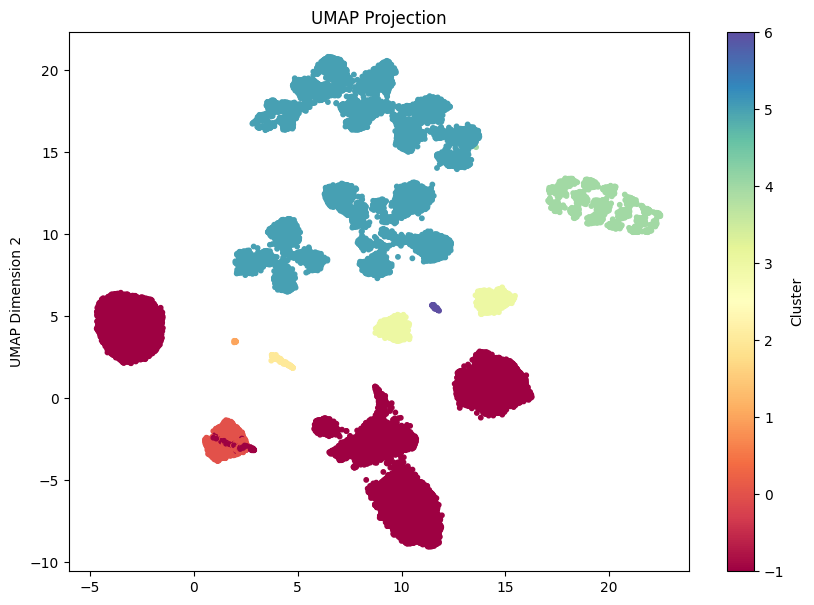

In [42]:
cust_info_sep_sc['cluster_dbscan'] = cust_info_sep['cluster_dbscan']
silhouette_dbscan = silhouette_score(cust_info_sep_sc, cust_info_sep_sc['cluster_dbscan'])

print('DBScan solution Silhouette Score: ' + str(round(silhouette_dbscan, 2)))
apply_umap(cust_info_sep_sc, 'cluster_dbscan')

In [43]:
cust_info_sep_sc.drop('cluster_dbscan', axis=1, inplace=True)

### Meanshift

In [44]:
round(estimate_bandwidth(cust_info_sep_sc, quantile=0.01), 2)

2.28

In [45]:
df_test_meanshift = cust_info_sep_sc.copy()
bandwith_test = np.arange(1.9, 2.31, 0.1)

for bt in bandwith_test:
    model = MeanShift(bandwidth=bt, bin_seeding=True, min_bin_freq=10, cluster_all=True)
    df_test_meanshift['clust_sol_curr'] = model.fit_predict(df_test_meanshift)

    print(bt)
    print(df_test_meanshift['clust_sol_curr'].value_counts())
    print()

    df_test_meanshift.drop('clust_sol_curr', axis=1, inplace=True)

1.9
clust_sol_curr
1    9175
0    8255
2    6723
4    5229
3    3849
5    3318
6    2118
7     233
8     206
Name: count, dtype: int64

2.0
clust_sol_curr
1    10685
0     9241
2     6743
3     5791
4     5413
6      656
5      348
7      229
Name: count, dtype: int64

2.1
clust_sol_curr
1    9138
0    8194
2    6620
5    5642
4    5067
3    3118
6    1058
7     269
Name: count, dtype: int64

2.2
clust_sol_curr
1    9356
0    8097
2    6592
5    5642
4    5039
3    3044
6    1059
7     277
Name: count, dtype: int64

2.3000000000000003
clust_sol_curr
1    9460
0    8031
2    6620
5    5642
4    5017
3    2986
6    1059
7     291
Name: count, dtype: int64



In [46]:
allocate_clusters_meanshift(cust_info_sep, cust_info_sep_sc, bandwidth = 2, bin_seeding=True, min_bin_freq=10, cluster_all=True)

In [47]:
show_clusters(cust_info_sep, cluster_column='cluster_meanshift', cluster_numbers=[0,1,2,3,4,5,6,7])

Cluster 0 size: 9241
Cluster 1 size: 10685
Cluster 2 size: 6743
Cluster 3 size: 5791
Cluster 4 size: 5413
Cluster 5 size: 348
Cluster 6 size: 656
Cluster 7 size: 229
Overall dataset size: 39106


,Overall Mean,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 3 Mean,Cluster 4 Mean,Cluster 5 Mean,Cluster 6 Mean,Cluster 7 Mean
kids_home,1.20,0.89,0.53,3.20,0.86,1.00,1.14,0.50,1.01
teens_home,0.94,0.41,0.83,2.06,0.73,1.00,1.08,0.29,1.00
number_complaints,0.74,0.48,0.80,0.99,0.90,0.50,2.96,0.33,0.57
distinct_stores_visited,1.74,1.19,2.74,1.11,1.89,1.36,1.89,1.29,2.19
lifetime_spend_groceries,5268.65,3365.63,2410.05,5030.42,5620.41,13790.82,3398.64,3763.98,19271.50
lifetime_spend_electronics,2204.17,633.76,623.08,2022.25,2136.81,8290.15,1105.53,2275.11,4017.72
typical_hour,13.56,13.81,12.69,17.69,9.93,13.58,14.15,13.20,15.05
lifetime_spend_vegetables,487.23,902.91,233.66,497.50,291.77,499.72,308.69,385.87,496.26
lifetime_spend_nonalcohol_drinks,438.27,324.38,331.72,505.05,577.00,600.54,303.60,575.96,506.25
lifetime_spend_alcohol_drinks,491.82,174.63,350.12,302.27,896.30,1009.11,1520.10,619.66,1099.46


MeanShift solution Silhouette Score: 0.25


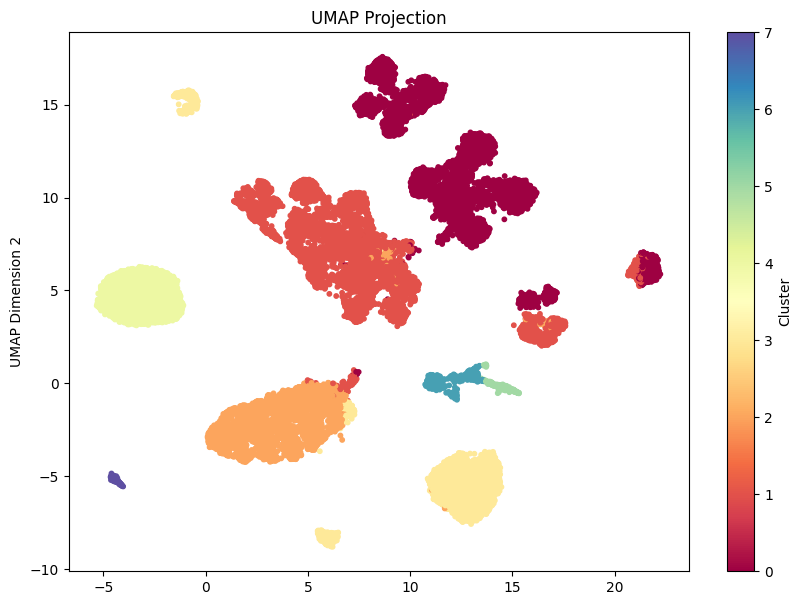

In [48]:
cust_info_sep_sc['cluster_meanshift'] = cust_info_sep['cluster_meanshift']
silhouette_meanshift = silhouette_score(cust_info_sep_sc, cust_info_sep_sc['cluster_meanshift'])

print('MeanShift solution Silhouette Score: ' + str(round(silhouette_meanshift, 2)))
apply_umap(cust_info_sep_sc, 'cluster_meanshift')

In [49]:
cust_info_sep_sc.drop('cluster_meanshift', axis=1, inplace=True)

### Segment Descriptions

In [50]:
cust_info_sep_final = cust_info_sep.copy()
cust_info_sep_final['cluster_solution'] = cust_info_sep_final['cluster_hierarchical']
cust_info_sep_final.drop(['cluster_hierarchical', 'cluster_kmeans', 'cluster_dbscan'], axis=1, inplace=True)
cust_info_sep_final.head()

,customer_name,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,latitude,longitude,age,gender,loyalty_program,education,vegetarian,lifetime_total_spent,cluster_meanshift,cluster_solution
customer_id,,,,,,,,,,,,,,,,,,,,,
46556,Ann Stansberry,0.0,0.0,0.0,1.0,8087.0,40.0,17.0,306.0,553.0,...,38.776432,-9.179869,37,1,False,12,0,17579.0,0,2
15771,Parker Lund,0.0,0.0,1.0,1.0,17969.0,82.0,8.0,290.0,572.0,...,38.730571,-9.153750,38,0,False,12,0,27467.0,3,2
36314,Rita Oliver,0.0,0.0,1.0,1.0,8506.0,10.0,9.0,83.0,466.0,...,38.727615,-9.134637,84,1,False,12,0,17778.0,3,2
36674,James Fobes,0.0,0.0,1.0,1.0,6672.0,252.0,NaN,246.0,638.0,...,38.755875,-9.171264,25,0,False,12,0,16191.0,0,2
8669,Harry Beaver,0.0,0.0,1.0,1.0,14139.0,28.0,8.0,4.0,546.0,...,38.732628,-9.198274,26,0,True,12,0,23268.0,3,2


In [51]:
solution = pd.concat([cust_info_sep_final.reset_index()[['customer_id', 'cluster_solution']], 
                      men_of_the_sea.reset_index()[['customer_id']].assign(cluster_solution=7),
                      pet_love.reset_index()[['customer_id']].assign(cluster_solution=8), 
                      uni_students.reset_index()[['customer_id']].assign(cluster_solution=9)],
                      ignore_index=True)

In [52]:
cluster_mapping_to_name = {
    0: "Big Spenders",
    1: "Veggie Heads",
    2: "Pet Lovers",
    3: "Newcomers",
    4: "Discount Queens",
    5: "Bricklayers",
    6: "Rubber Deniers", 
    7: 'Men of the Sea',
    8: 'Pet Lovers',
    9: 'Uni Students'
}
solution['cluster_solution_name'] = solution['cluster_solution'].map(cluster_mapping_to_name)

(43631, 25)
(43631, 3)



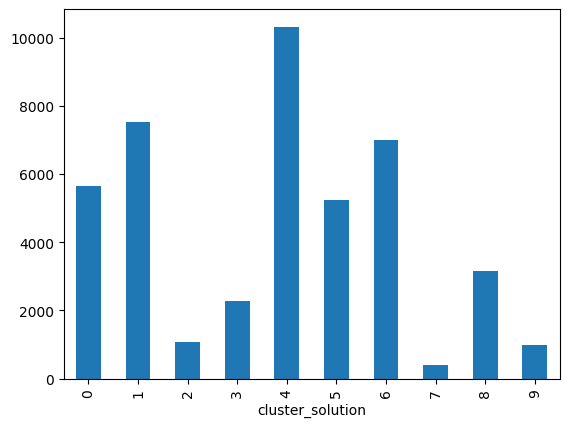

In [53]:
# verify if all customers have been assigned
print(cust_info.shape)
print(solution.shape)
print()
plot_cluster_sizes(solution, name_column='cluster_solution')

In [54]:
solution.to_csv('final_solution.csv')

## Association Rules

We know it would be best to divide the dataset into train and test, and evaluate how well the rules describe the entire population, but due to time constraints this was not possible for us to do. In a future project, this would be something to improve on.

In [55]:
clustered_baskets = association_rules_preproc(solution, basket_encoded)

In [56]:
for cluster in clustered_baskets.keys():
  association_rules_apriori(clustered_baskets, cluster)

Cluster Big Spenders:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
361,(laptop),"(champagne, samsung galaxy 10)",0.258530,0.395553,0.117493,0.454464,1.148932,0.015230,1.107987,0.174824
357,"(champagne, samsung galaxy 10)",(laptop),0.395553,0.258530,0.117493,0.297034,1.148932,0.015230,1.054773,0.214455
159,"(airpods, champagne)",(bluetooth headphones),0.271345,0.388683,0.120349,0.443528,1.141104,0.014882,1.098558,0.169704
163,(bluetooth headphones),"(airpods, champagne)",0.388683,0.271345,0.120349,0.309633,1.141104,0.014882,1.055460,0.202277
358,"(champagne, laptop)",(samsung galaxy 10),0.203721,0.506948,0.117493,0.576734,1.137659,0.014217,1.164875,0.151959
360,(samsung galaxy 10),"(champagne, laptop)",0.506948,0.203721,0.117493,0.231765,1.137659,0.014217,1.036504,0.245414
381,"(champagne, samsung galaxy 10)",(spaghetti),0.395553,0.303690,0.136483,0.345043,1.136168,0.016357,1.063138,0.198278
382,(spaghetti),"(champagne, samsung galaxy 10)",0.303690,0.395553,0.136483,0.449415,1.136168,0.016357,1.097827,0.172120
379,"(spaghetti, champagne)",(samsung galaxy 10),0.236992,0.506948,0.136483,0.575896,1.136006,0.016340,1.162573,0.156910
383,(samsung galaxy 10),"(spaghetti, champagne)",0.506948,0.236992,0.136483,0.269225,1.136006,0.016340,1.044107,0.242821


Cluster Bricklayers:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
174,"(cake, oil)",(muffins),0.371017,0.249231,0.106813,0.287892,1.155125,0.014344,1.054292,0.213508
175,(muffins),"(cake, oil)",0.249231,0.371017,0.106813,0.428571,1.155125,0.014344,1.100720,0.178873
249,(fresh bread),"(cooking oil, oil)",0.185176,0.472922,0.100657,0.543576,1.149398,0.013083,1.154798,0.159518
248,"(cooking oil, oil)",(fresh bread),0.472922,0.185176,0.100657,0.212841,1.149398,0.013083,1.035145,0.246603
261,(cooking oil),"(gums, oil)",0.570834,0.246984,0.161384,0.282716,1.144673,0.020397,1.049816,0.294497
260,"(gums, oil)",(cooking oil),0.246984,0.570834,0.161384,0.653419,1.144673,0.020397,1.238283,0.167842
262,(gums),"(cooking oil, oil)",0.298311,0.472922,0.161384,0.540993,1.143936,0.020306,1.148299,0.179317
259,"(cooking oil, oil)",(gums),0.472922,0.298311,0.161384,0.341249,1.143936,0.020306,1.065180,0.238722
173,"(muffins, oil)",(cake),0.211214,0.442559,0.106813,0.505711,1.142698,0.013339,1.127763,0.158316
176,(cake),"(muffins, oil)",0.442559,0.211214,0.106813,0.241353,1.142698,0.013339,1.039728,0.224020


Cluster Discount Queens:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
49,(white wine),(cider),0.248894,0.184792,0.139410,0.560117,3.031062,0.093416,1.853239,0.892128
48,(cider),(white wine),0.184792,0.248894,0.139410,0.754414,3.031062,0.093416,3.058428,0.821978
70,(white wine),(dessert wine),0.248894,0.143231,0.105792,0.425047,2.967560,0.070142,1.490155,0.882729
69,(dessert wine),(white wine),0.143231,0.248894,0.105792,0.738609,2.967560,0.070142,2.873496,0.773864
188,(cooking oil),"(gums, oil)",0.423597,0.179383,0.114379,0.270018,1.505264,0.038393,1.124162,0.582344
187,"(gums, oil)",(cooking oil),0.179383,0.423597,0.114379,0.637626,1.505264,0.038393,1.590628,0.409039
122,"(cake, oil)",(cooking oil),0.261732,0.423597,0.165085,0.630741,1.489013,0.054216,1.560974,0.444844
123,(cooking oil),"(cake, oil)",0.423597,0.261732,0.165085,0.389722,1.489013,0.054216,1.209725,0.569765
155,(cooking oil),"(candy bars, oil)",0.423597,0.213473,0.134644,0.317859,1.488991,0.044218,1.153028,0.569747
154,"(candy bars, oil)",(cooking oil),0.213473,0.423597,0.134644,0.630732,1.488991,0.044218,1.560934,0.417537


Cluster Newcomers:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
35,(candy bars),(muffins),0.346321,0.260087,0.106013,0.306111,1.176955,0.015939,1.066327,0.230006
34,(muffins),(candy bars),0.260087,0.346321,0.106013,0.407605,1.176955,0.015939,1.103450,0.203200
275,(napkins),"(cooking oil, oil)",0.237540,0.475475,0.130934,0.551207,1.159278,0.017989,1.168748,0.180198
272,"(cooking oil, oil)",(napkins),0.475475,0.237540,0.130934,0.275374,1.159278,0.017989,1.052213,0.261940
176,"(cake, oil)",(muffins),0.365902,0.260087,0.109771,0.300000,1.153460,0.014604,1.057019,0.209815
177,(muffins),"(cake, oil)",0.260087,0.365902,0.109771,0.422053,1.153460,0.014604,1.097157,0.179809
273,"(napkins, oil)",(cooking oil),0.199960,0.568038,0.130934,0.654797,1.152735,0.017348,1.251328,0.165614
274,(cooking oil),"(napkins, oil)",0.568038,0.199960,0.130934,0.230501,1.152735,0.017348,1.039689,0.306735
175,"(muffins, oil)",(cake),0.218354,0.436511,0.109771,0.502717,1.151672,0.014456,1.133136,0.168487
178,(cake),"(muffins, oil)",0.436511,0.218354,0.109771,0.251473,1.151672,0.014456,1.044244,0.233717


Cluster Rubber Deniers:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
222,(napkins),"(cooking oil, babies food)",0.228586,0.472666,0.123094,0.538503,1.139288,0.015049,1.142659,0.158487
218,"(cooking oil, babies food)",(napkins),0.472666,0.228586,0.123094,0.260425,1.139288,0.015049,1.043051,0.231844
205,(gums),"(babies food, cooking oil)",0.302777,0.472666,0.162824,0.537769,1.137734,0.019711,1.140843,0.173632
202,"(babies food, cooking oil)",(gums),0.472666,0.302777,0.162824,0.344479,1.137734,0.019711,1.063618,0.229570
216,(muffins),"(cooking oil, babies food)",0.262551,0.472666,0.140821,0.536355,1.134743,0.016722,1.137365,0.161019
215,"(cooking oil, babies food)",(muffins),0.472666,0.262551,0.140821,0.297928,1.134743,0.016722,1.050389,0.225177
275,(cake),"(cooking oil, candy bars)",0.438019,0.219536,0.108838,0.248479,1.131834,0.012677,1.038512,0.207264
273,"(cooking oil, candy bars)",(cake),0.219536,0.438019,0.108838,0.495765,1.131834,0.012677,1.114522,0.149243
65,(muffins),(candy bars),0.262551,0.361659,0.107413,0.409112,1.131211,0.012459,1.080309,0.157288
66,(candy bars),(muffins),0.361659,0.262551,0.107413,0.297001,1.131211,0.012459,1.049004,0.181708


Cluster Veggie Heads:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
309,"(carrots, asparagus)","(mashed potato, tomatoes)",0.369030,0.268909,0.124143,0.336403,1.250991,0.024907,1.101709,0.317977
314,"(mashed potato, tomatoes)","(carrots, asparagus)",0.268909,0.369030,0.124143,0.461654,1.250991,0.024907,1.172052,0.274431
313,"(asparagus, mashed potato)","(carrots, tomatoes)",0.231638,0.430785,0.124143,0.535936,1.244092,0.024357,1.226588,0.255349
310,"(carrots, tomatoes)","(asparagus, mashed potato)",0.430785,0.231638,0.124143,0.288179,1.244092,0.024357,1.079431,0.344687
312,"(asparagus, tomatoes)","(carrots, mashed potato)",0.511838,0.196555,0.124143,0.242544,1.233973,0.023539,1.060714,0.388415
311,"(carrots, mashed potato)","(asparagus, tomatoes)",0.196555,0.511838,0.124143,0.631594,1.233973,0.023539,1.325066,0.235995
305,"(carrots, asparagus, tomatoes)",(mashed potato),0.311654,0.326862,0.124143,0.398336,1.218668,0.022275,1.118794,0.260671
316,(mashed potato),"(carrots, asparagus, tomatoes)",0.326862,0.311654,0.124143,0.379803,1.218668,0.022275,1.109882,0.266560
164,"(asparagus, tomatoes)",(green beans),0.511838,0.173109,0.106458,0.207991,1.201503,0.017854,1.044042,0.343552
165,(green beans),"(asparagus, tomatoes)",0.173109,0.511838,0.106458,0.614975,1.201503,0.017854,1.267870,0.202819


Cluster Men of the Sea:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
87,(salmon),(oil),0.426843,0.193619,0.101210,0.237113,1.224637,0.018565,1.057012,0.320037
86,(oil),(salmon),0.193619,0.426843,0.101210,0.522727,1.224637,0.018565,1.200901,0.227475
180,"(fresh tuna, shrimp)",(catfish),0.443344,0.243124,0.124312,0.280397,1.153307,0.016525,1.051796,0.238798
183,(catfish),"(fresh tuna, shrimp)",0.243124,0.443344,0.124312,0.511312,1.153307,0.016525,1.139082,0.175628
280,"(shrimp, salmon)",(seabass),0.342134,0.287129,0.111111,0.324759,1.131057,0.012875,1.055728,0.176132
281,(seabass),"(shrimp, salmon)",0.287129,0.342134,0.111111,0.386973,1.131057,0.012875,1.073144,0.162541
278,"(seabass, shrimp)",(salmon),0.231023,0.426843,0.111111,0.480952,1.126767,0.012501,1.104248,0.146305
282,(salmon),"(seabass, shrimp)",0.426843,0.231023,0.111111,0.260309,1.126767,0.012501,1.039592,0.196290
52,(french fries),(shrimp),0.151815,0.778878,0.133113,0.876812,1.125737,0.014868,1.794991,0.131685
181,"(catfish, shrimp)",(fresh tuna),0.201320,0.553355,0.124312,0.617486,1.115895,0.012911,1.167657,0.130037


Cluster Uni Students:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
84,(beer),"(cider, white wine)",0.296679,0.364901,0.131059,0.441755,1.210615,0.022801,1.137670,0.247360
81,"(cider, white wine)",(beer),0.364901,0.296679,0.131059,0.359164,1.210615,0.022801,1.097505,0.273931
121,(cider),"(dessert wine, white wine)",0.475314,0.260323,0.146768,0.308782,1.186148,0.023033,1.070106,0.299103
118,"(dessert wine, white wine)",(cider),0.260323,0.475314,0.146768,0.563793,1.186148,0.023033,1.202837,0.212167
120,(dessert wine),"(cider, white wine)",0.339318,0.364901,0.146768,0.432540,1.185361,0.022951,1.119195,0.236687
119,"(cider, white wine)",(dessert wine),0.364901,0.339318,0.146768,0.402214,1.185361,0.022951,1.105215,0.246222
83,(cider),"(beer, white wine)",0.475314,0.234740,0.131059,0.275732,1.174628,0.019484,1.056598,0.283344
82,"(beer, white wine)",(cider),0.234740,0.475314,0.131059,0.558317,1.174628,0.019484,1.187925,0.194269
5,(beer),(cider),0.296679,0.475314,0.162029,0.546142,1.149013,0.021013,1.156058,0.184393
6,(cider),(beer),0.475314,0.296679,0.162029,0.340888,1.149013,0.021013,1.067074,0.247172


The higher the lift, the more specific the association rules are to the cluster at hand. To find better lift, we try lowering the minimum support